#***TelecomX  - Análisis de Evación de Clientes***

---



---



📥 1) EXTRACCIÓN (desde URL / “API”)

In [45]:
# 📥 EXTRACCIÓN: carga y normalización básica
import pandas as pd
import requests
from IPython.display import display

RAW_URL = "https://raw.githubusercontent.com/Alxs68/TelecomX_LATAM/main/TelecomX_Data.json"

resp = requests.get(RAW_URL, timeout=30)
resp.raise_for_status()
data = resp.json()

df_raw = pd.json_normalize(data, sep=".")
print("✅ Cargado. Forma:", df_raw.shape)
display(df_raw.head())


✅ Cargado. Forma: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


2) 🧹 Limpieza & coherencia → df_clean

In [ ]:
# 🧹 LIMPIEZA & COHERENCIA: crea df_clean (simple y seguro)
import pandas as pd
from IPython.display import display

df_clean = df_raw.copy()

# 1) Strip en textos
for c in df_clean.select_dtypes(include="object").columns:
    df_clean[c] = df_clean[c].astype(str).str.strip()

# 2) Churn: vacío → "Desconocido"
if "Churn" in df_clean.columns:
    vac = (df_clean["Churn"] == "").sum()
    df_clean["Churn"] = df_clean["Churn"].replace("", "Desconocido")
    print(f"• Churn vacíos → 'Desconocido': {vac}")

# 3) Unificar "no aplica" → "No" en servicios
to_no = [
    "phone.MultipleLines",
    "internet.OnlineSecurity","internet.OnlineBackup","internet.DeviceProtection",
    "internet.TechSupport","internet.StreamingTV","internet.StreamingMovies"
]
for c in to_no:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].replace({"No phone service":"No", "No internet service":"No"})

# 4) Reglas simples de coherencia
if {"phone.PhoneService","phone.MultipleLines"}.issubset(df_clean.columns):
    m = (df_clean["phone.PhoneService"]=="No") & (df_clean["phone.MultipleLines"]!="No")
    df_clean.loc[m, "phone.MultipleLines"] = "No"
if "internet.InternetService" in df_clean.columns:
    sin_inet = df_clean["internet.InternetService"]=="No"
    for c in to_no:
        if c in df_clean.columns:
            df_clean.loc[sin_inet, c] = "No"

# 5) Numéricos seguros
for col in ["account.Charges.Monthly","account.Charges.Total","customer.tenure"]:
    if col in df_clean.columns:
        df_clean[col] = (
            df_clean[col].astype(str)
                         .str.replace("$","", regex=False)
                         .str.replace(",",".", regex=False)
                         .replace("", pd.NA)
        )
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# 6) Tenure no negativo
if "customer.tenure" in df_clean.columns:
    neg = (df_clean["customer.tenure"] < 0).sum()
    df_clean.loc[df_clean["customer.tenure"] < 0, "customer.tenure"] = pd.NA
    if neg: print("• Tenure negativos → NaN:", int(neg))

# 7) Duplicados por customerID (opcional: mantener primero)
if "customerID" in df_clean.columns:
    antes = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=["customerID"], keep="first")
    quitados = antes - len(df_clean)
    if quitados: print("• Duplicados por customerID quitados:", quitados)

print("✅ df_clean listo. Forma:", df_clean.shape)
display(df_clean.head())


3) 🧱 Estandarización con Traducción


In [33]:
# 🧱 ESTANDARIZACIÓN + TRADUCCIÓN
import pandas as pd
from IPython.display import display

df_std = df_clean.copy()

# Flags 0/1 desde Yes/No
def yes_no_to_bin(s):
    return s.astype(str).str.strip().map({"Yes":1,"No":0,"yes":1,"no":0})

flag_cols = [
    "phone.PhoneService","phone.MultipleLines",
    "internet.OnlineSecurity","internet.OnlineBackup","internet.DeviceProtection",
    "internet.TechSupport","internet.StreamingTV","internet.StreamingMovies",
    "account.PaperlessBilling"
]
for c in flag_cols:
    if c in df_std.columns:
        df_std[c+"_flag"] = yes_no_to_bin(df_std[c])

# Objetivo binario
if "Churn" in df_std.columns:
    df_std["Churn_flag"] = df_std["Churn"].astype(str).str.strip().map({"Yes":1,"No":0})

# Indicador de internet
if "internet.InternetService" in df_std.columns:
    df_std["TieneInternet_flag"] = (df_std["internet.InternetService"].astype(str).str.strip()!="No").astype("int")

# Cuentas_Diarias (si hay cargo mensual)
if "account.Charges.Monthly" in df_std.columns:
    DIAS_POR_MES = 30.44
    df_std["Cuentas_Diarias"] = (pd.to_numeric(df_std["account.Charges.Monthly"], errors="coerce")/DIAS_POR_MES).round(2)

# ---- Traducción 1:1 a español (todas las columnas) ----
base_map = {
    "customerID":"id_cliente", "Churn":"churn", "Churn_flag":"churn_flag",
    "Cuentas_Diarias":"cuentas_diarias", "TieneInternet_flag":"tiene_internet_flag",
    "customer.gender":"genero","customer.SeniorCitizen":"adulto_mayor","customer.Partner":"pareja",
    "customer.Dependents":"dependientes","customer.tenure":"antiguedad_meses",
    "phone.PhoneService":"servicio_telefonia","phone.MultipleLines":"multiples_lineas",
    "internet.InternetService":"tipo_internet","internet.OnlineSecurity":"seguridad_en_linea",
    "internet.OnlineBackup":"respaldo_en_linea","internet.DeviceProtection":"proteccion_dispositivo",
    "internet.TechSupport":"soporte_tecnico","internet.StreamingTV":"streaming_tv",
    "internet.StreamingMovies":"streaming_peliculas",
    "account.Contract":"tipo_contrato","account.PaperlessBilling":"facturacion_electronica",
    "account.PaymentMethod":"metodo_pago","account.Charges.Monthly":"cargo_mensual",
    "account.Charges.Total":"cargo_total",
}
def traducir(col:str)->str:
    if col in base_map: return base_map[col]
    if col.endswith("_flag"):
        base = col[:-5]
        return f"{traducir(base)}_flag"
    nombre = col.replace(".","_")
    nombre = (nombre
              .replace("customer_","")
              .replace("phone_","telefono_")
              .replace("internet_","internet_")
              .replace("account_","cuenta_"))
    # reemplazos sencillos
    repl = {
        "gender":"genero","SeniorCitizen":"adulto_mayor","Partner":"pareja","Dependents":"dependientes",
        "tenure":"antiguedad_meses","PhoneService":"servicio_telefonia","MultipleLines":"multiples_lineas",
        "InternetService":"tipo_internet","OnlineSecurity":"seguridad_en_linea","OnlineBackup":"respaldo_en_linea",
        "DeviceProtection":"proteccion_dispositivo","TechSupport":"soporte_tecnico",
        "StreamingTV":"streaming_tv","StreamingMovies":"streaming_peliculas",
        "Contract":"tipo_contrato","PaperlessBilling":"facturacion_electronica","PaymentMethod":"metodo_pago",
        "Charges_Monthly":"cargo_mensual","Charges_Total":"cargo_total",
    }
    for k,v in repl.items(): nombre = nombre.replace(k,v)
    return nombre.lower()

rename_dict = {}
usados = set()
for c in df_std.columns:
    nuevo = traducir(c)
    if nuevo in usados:
        suf=2
        while f"{nuevo}_{suf}" in usados: suf+=1
        nuevo = f"{nuevo}_{suf}"
    usados.add(nuevo)
    rename_dict[c] = nuevo

df_std_full_es = df_std.rename(columns=rename_dict).copy()
# Normaliza churn vacío a 'Desconocido' solo para visualización
df_std_full_es["churn"] = df_std_full_es["churn"].astype(str).str.strip().replace({"": "Desconocido"})

print("✅ df_std y df_std_full_es creados. Forma:", df_std_full_es.shape)
display(df_std_full_es.head())


✅ df_std y df_std_full_es creados. Forma: (7267, 33)


,id_cliente,churn,genero,adulto_mayor,pareja,dependientes,antiguedad_meses,servicio_telefonia,multiples_lineas,tipo_internet,...,multiples_lineas_flag,seguridad_en_linea_flag,respaldo_en_linea_flag,proteccion_dispositivo_flag,soporte_tecnico_flag,streaming_tv_flag,streaming_peliculas_flag,facturacion_electronica_flag,churn_flag,tiene_internet_flag
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,0,0,1,0,1,1,0,1,0.0,1
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,1,0,0,0,0,0,1,0,0.0,1
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,0,0,0,1,0,0,0,1,1.0,1
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,0,0,1,1,0,1,1,1,1.0,1
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,0,0,0,0,1,1,0,1,1.0,1


4) 📈 Análisis Descriptivo

In [34]:
# 📈 ANÁLISIS DESCRIPTIVO (usa df_std_full_es)
import pandas as pd
from IPython.display import display

if 'df_std_full_es' not in globals():
    raise RuntimeError("Falta df_std_full_es. Ejecuta las celdas anteriores.")

num_cols = [c for c in ['antiguedad_meses','cargo_mensual','cargo_total','cuentas_diarias']
            if c in df_std_full_es.columns]
if not num_cols:
    num_cols = list(df_std_full_es.select_dtypes(include='number').columns)

num_tmp = df_std_full_es[num_cols].apply(pd.to_numeric, errors='coerce')

print("📊 Estadísticos generales:")
display(num_tmp.describe())

print("\n➕ Medianas:")
display(num_tmp.median().to_frame('mediana').T)

if 'churn' in df_std_full_es.columns:
    print("\n📊 Métricas por churn (count/mean/median/std):")
    aux = num_tmp.copy()
    aux['churn'] = df_std_full_es['churn']
    display(aux.groupby('churn')[num_cols].agg(['count','mean','median','std']))


📊 Estadísticos generales:


,antiguedad_meses,cargo_mensual,cargo_total,cuentas_diarias
count,7267.000000,7267.000000,7256.000000,7267.000000
mean,32.346498,64.720098,2280.634213,2.126155
std,24.571773,30.129572,2268.632997,0.989744
min,0.000000,18.250000,18.800000,0.600000
25%,9.000000,35.425000,400.225000,1.160000
50%,29.000000,70.300000,1391.000000,2.310000
75%,55.000000,89.875000,3785.300000,2.950000
max,72.000000,118.750000,8684.800000,3.900000



➕ Medianas:


,antiguedad_meses,cargo_mensual,cargo_total,cuentas_diarias
mediana,29.0,70.3,1391.0,2.31



📊 Métricas por churn (count/mean/median/std):


antiguedad_meses                              cargo_mensual  \
                       count       mean median        std         count   
churn                                                                     
Desconocido              224  31.571429   29.0  24.998552           224   
No                      5174  37.569965   38.0  24.113777          5174   
Yes                     1869  17.979133   10.0  19.531123          1869   

                                          cargo_total                         \
                  mean  median        std       count         mean    median   
churn                                                                          
Desconocido  63.412277  69.100  31.388712         224  2196.933705  1163.175   
No           61.265124  64.425  31.092648        5163  2555.344141  1683.600   
Yes          74.441332  79.650  24.666053        1869  1531.796094   703.550   

                         cuentas_diarias                             
                     std           count      mean median       std  
churn                                                                
Desconocido  2329.961954             224  2.083214   2.27  1.031434  
No           2329.456984            5174  2.012685   2.12  1.021346  
Yes          1890.822994            1869  2.445425   2.62  0.810376

# 📊 Distribiusión de Evasión

📋 Resumen churn:


,conteo,porcentaje_%
churn,,
Yes,1869,25.7
No,5174,71.2
Desconocido,224,3.1


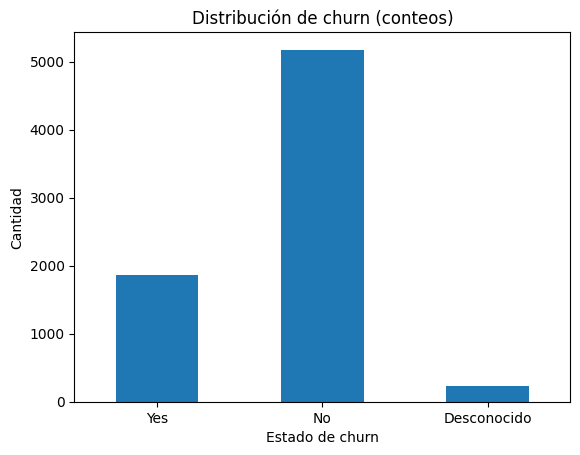

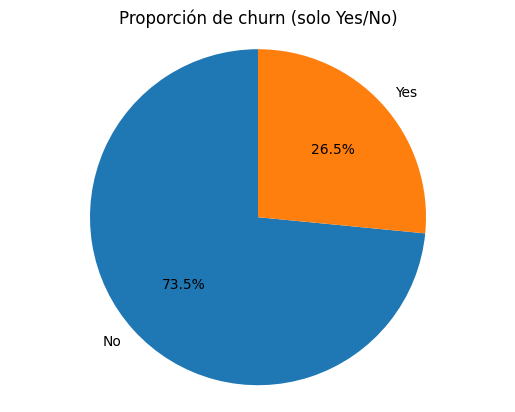

In [38]:
# 📊 Distribución de Evasión (Churn)
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

ser = df_std_full_es['churn'].astype(str).str.strip().replace({'': 'Desconocido'})
vc = ser.value_counts(dropna=False)
pct = (vc/len(ser)*100).round(1)
resumen = pd.DataFrame({'conteo':vc, 'porcentaje_%':pct})
orden = [c for c in ['Yes','No','Desconocido'] if c in resumen.index]
if orden: resumen = resumen.loc[orden]

print("📋 Resumen churn:")
display(resumen)

print("")
plt.figure()
resumen['conteo'].plot(kind='bar')
plt.title('Distribución de churn (conteos)')
plt.xlabel('Estado de churn'); plt.ylabel('Cantidad'); plt.xticks(rotation=0)
plt.show()

val_bin = ser.isin(['Yes','No'])
vc_bin = ser.loc[val_bin].value_counts()
print("")
plt.figure()
plt.pie(vc_bin.values, labels=vc_bin.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de churn (solo Yes/No)')
plt.axis('equal')
plt.show()


🗂️ Evasión por Categorías

✅ Categóricas a analizar: ['genero', 'tipo_contrato', 'metodo_pago', 'facturacion_electronica', 'tipo_internet', 'servicio_telefonia', 'multiples_lineas', 'seguridad_en_linea', 'respaldo_en_linea', 'soporte_tecnico', 'streaming_tv', 'streaming_peliculas']

🔠 genero — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
genero,,,,
Male,3555,930,2625,26.16
Female,3488,939,2549,26.92


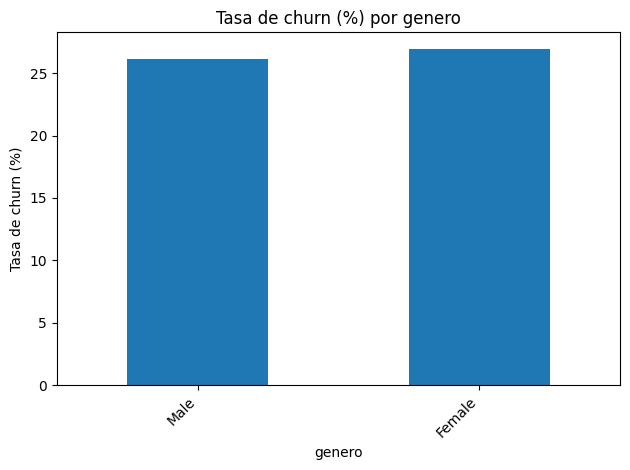

<Figure size 640x480 with 0 Axes>

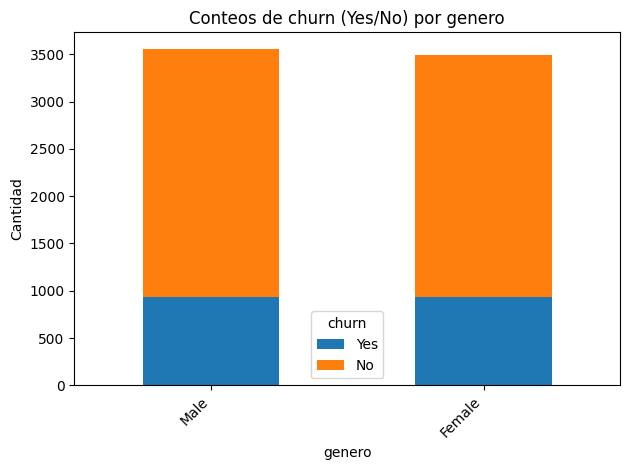


🔠 tipo_contrato — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
tipo_contrato,,,,
Month-to-month,3875,1655,2220,42.71
Two year,1695,48,1647,2.83
One year,1473,166,1307,11.27


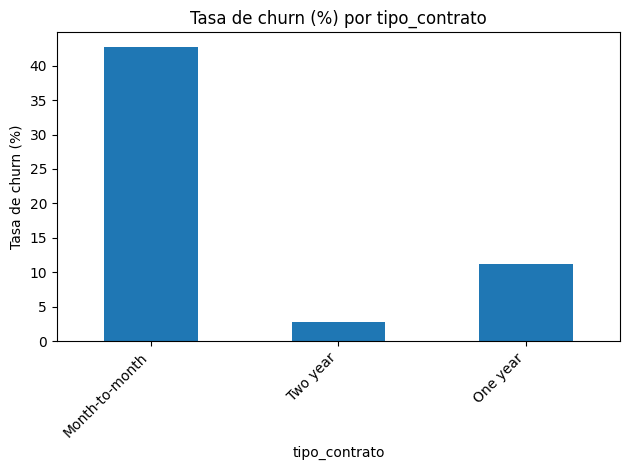

<Figure size 640x480 with 0 Axes>

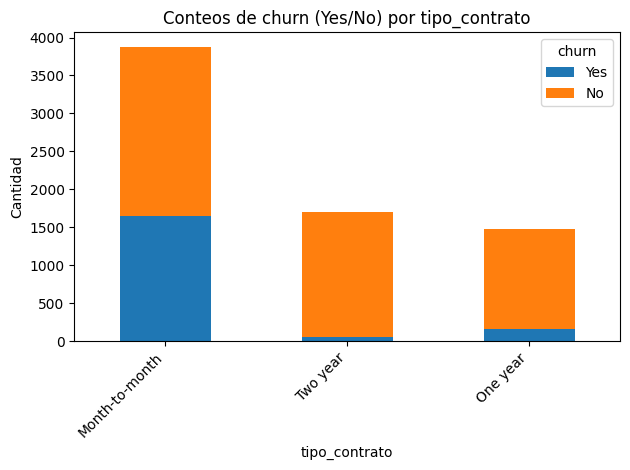


🔠 metodo_pago — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
metodo_pago,,,,
Electronic check,2365,1071,1294,45.29
Mailed check,1612,308,1304,19.11
Bank transfer (automatic),1544,258,1286,16.71
Credit card (automatic),1522,232,1290,15.24


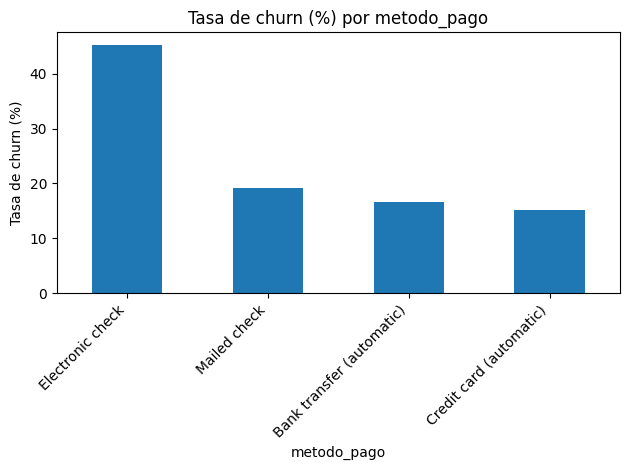

<Figure size 640x480 with 0 Axes>

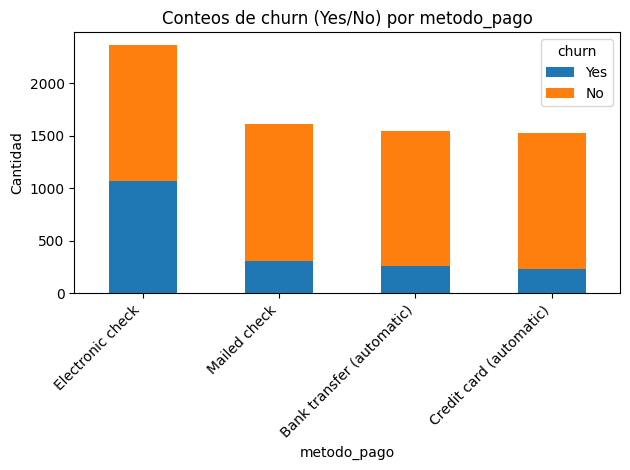


🔠 facturacion_electronica — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
facturacion_electronica,,,,
Yes,4171,1400,2771,33.57
No,2872,469,2403,16.33


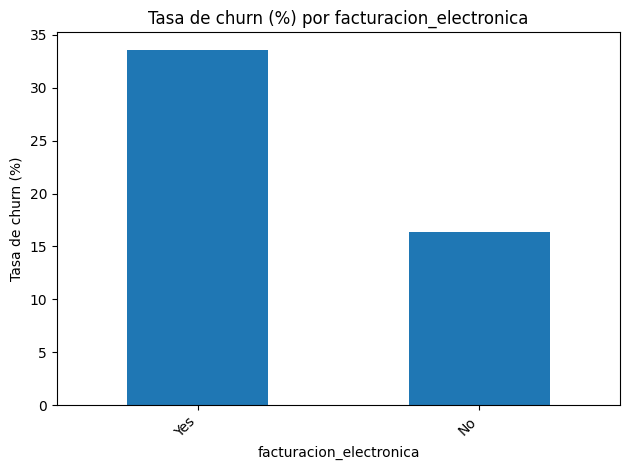

<Figure size 640x480 with 0 Axes>

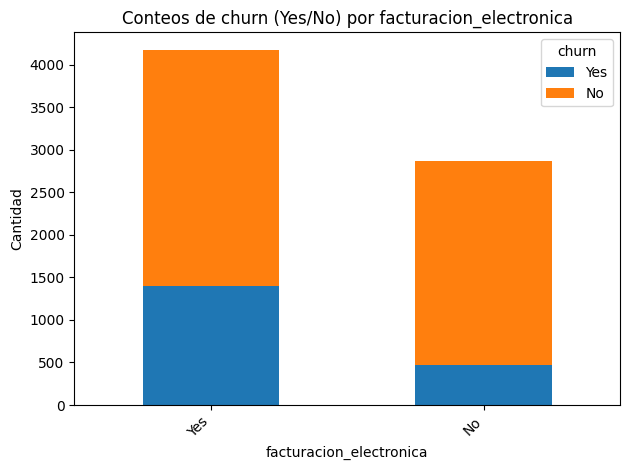


🔠 tipo_internet — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
tipo_internet,,,,
Fiber optic,3096,1297,1799,41.89
DSL,2421,459,1962,18.96
No,1526,113,1413,7.40


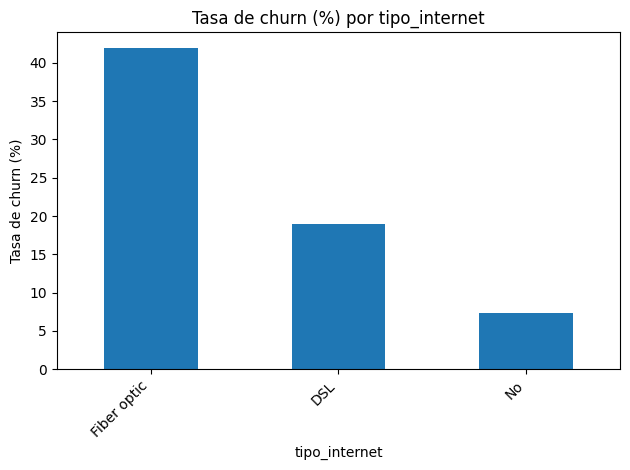

<Figure size 640x480 with 0 Axes>

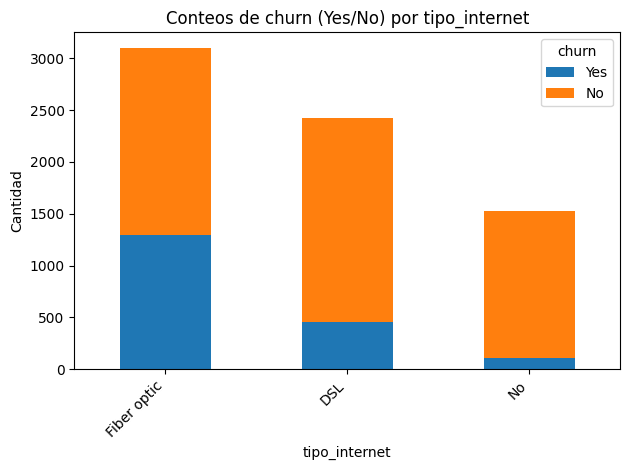


🔠 servicio_telefonia — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
servicio_telefonia,,,,
Yes,6361,1699,4662,26.71
No,682,170,512,24.93


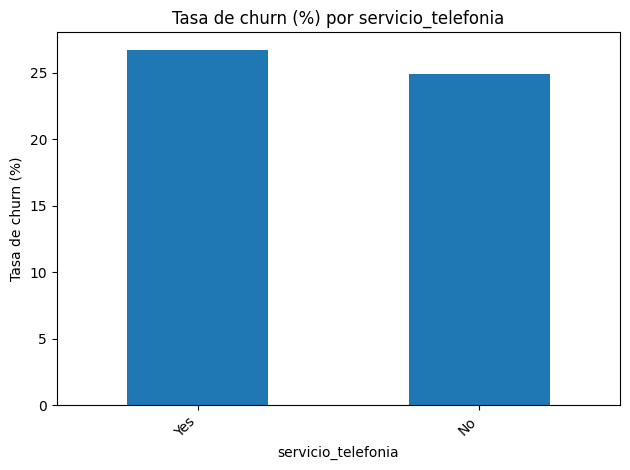

<Figure size 640x480 with 0 Axes>

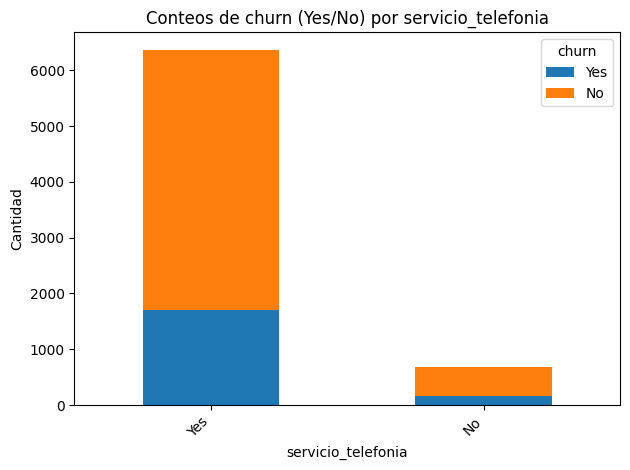


🔠 multiples_lineas — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
multiples_lineas,,,,
No,4072,1019,3053,25.02
Yes,2971,850,2121,28.61


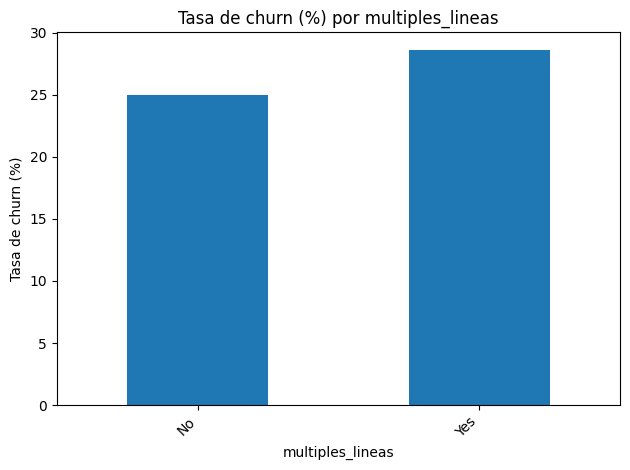

<Figure size 640x480 with 0 Axes>

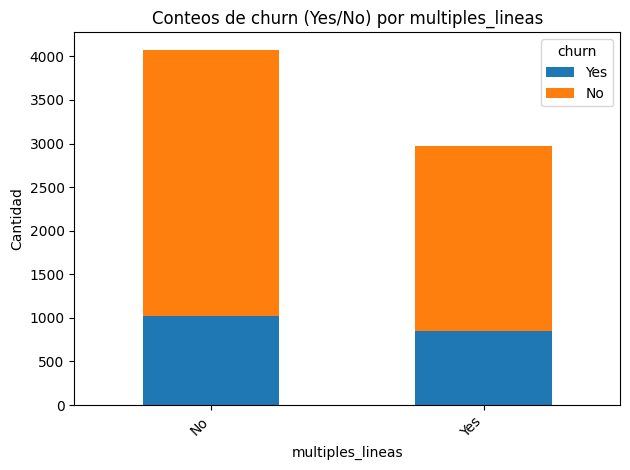


🔠 seguridad_en_linea — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
seguridad_en_linea,,,,
No,5024,1574,3450,31.33
Yes,2019,295,1724,14.61


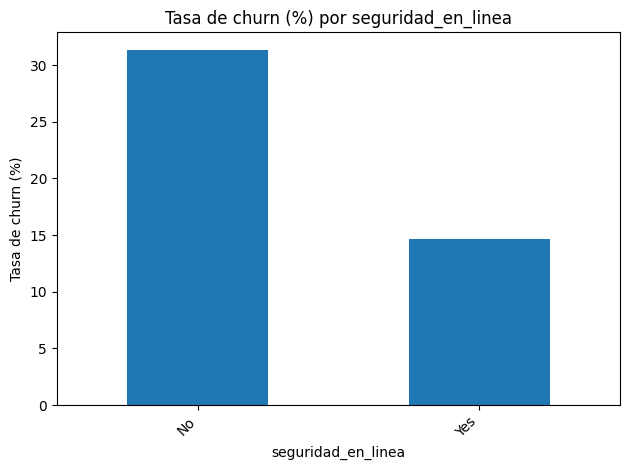

<Figure size 640x480 with 0 Axes>

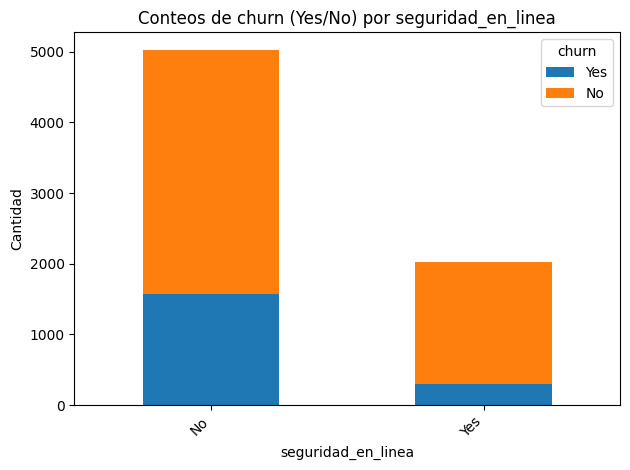


🔠 respaldo_en_linea — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
respaldo_en_linea,,,,
No,4614,1346,3268,29.17
Yes,2429,523,1906,21.53


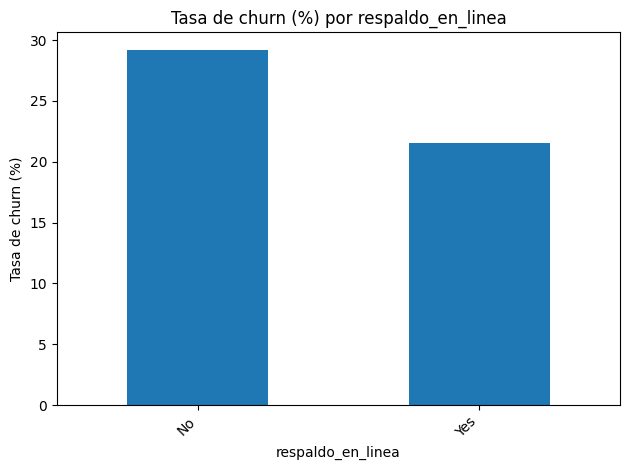

<Figure size 640x480 with 0 Axes>

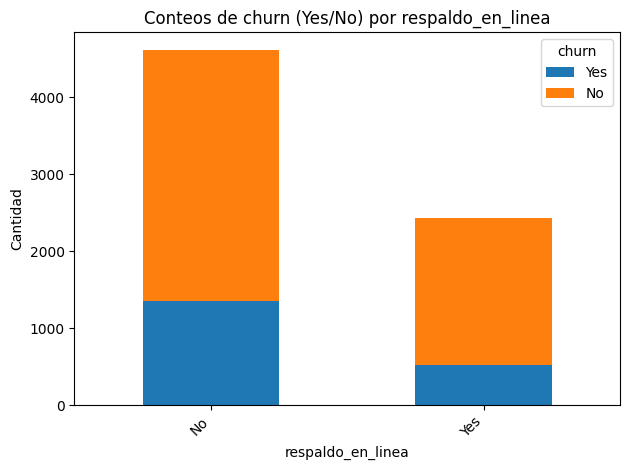


🔠 soporte_tecnico — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
soporte_tecnico,,,,
No,4999,1559,3440,31.19
Yes,2044,310,1734,15.17


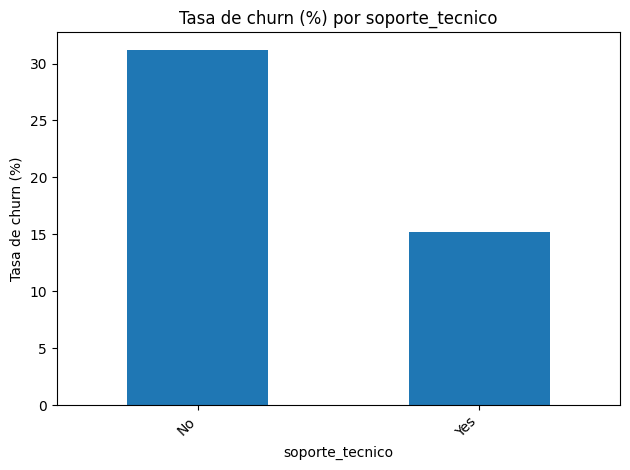

<Figure size 640x480 with 0 Axes>

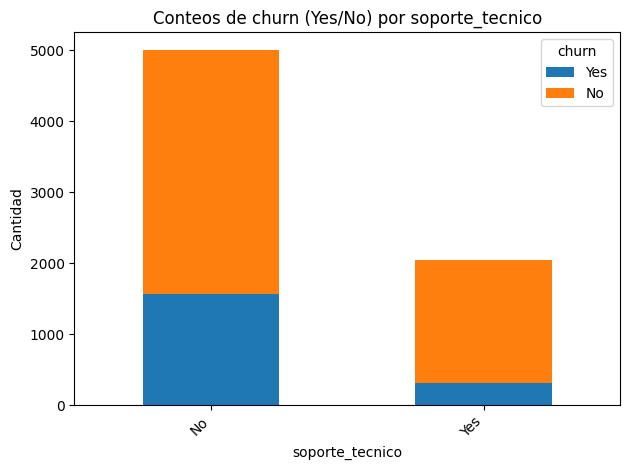


🔠 streaming_tv — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
streaming_tv,,,,
No,4336,1055,3281,24.33
Yes,2707,814,1893,30.07


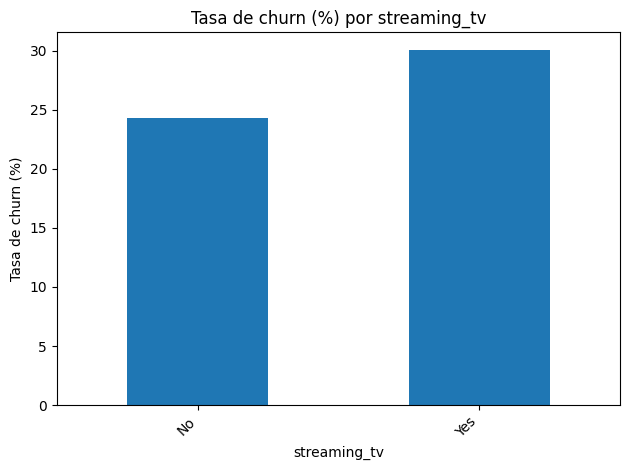

<Figure size 640x480 with 0 Axes>

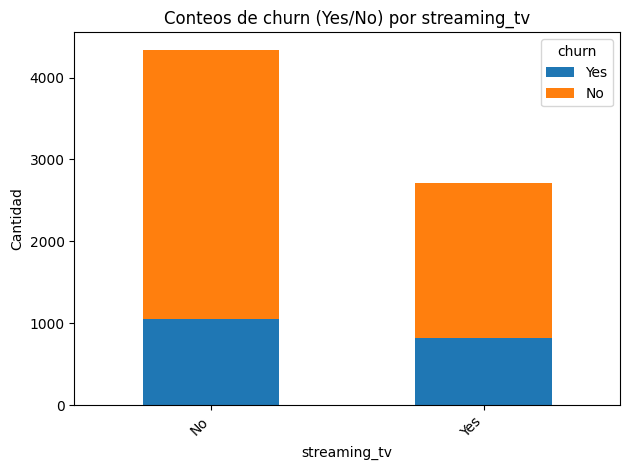


🔠 streaming_peliculas — churn por categoría


churn,clientes,Yes,No,tasa_churn_%
streaming_peliculas,,,,
No,4311,1051,3260,24.38
Yes,2732,818,1914,29.94


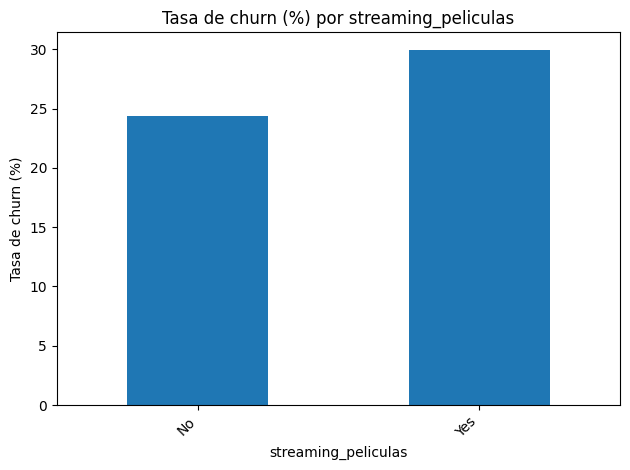

<Figure size 640x480 with 0 Axes>

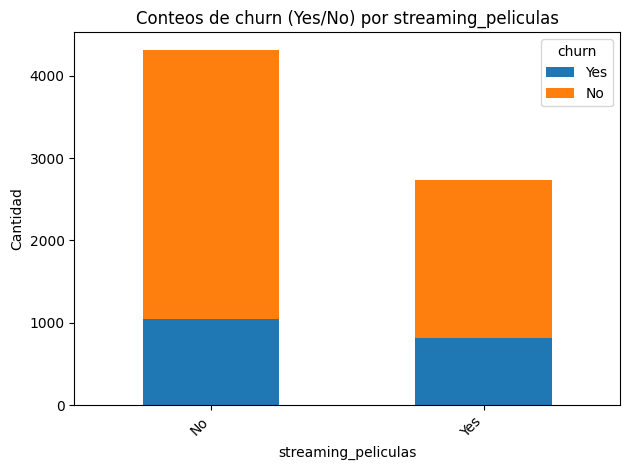

In [39]:
# 🗂️ Evasión por Categorías (tablas + gráficos)
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

cat_cols = [c for c in [
    'genero','tipo_contrato','metodo_pago','facturacion_electronica',
    'tipo_internet','servicio_telefonia','multiples_lineas',
    'seguridad_en_linea','respaldo_en_linea','soporte_tecnico',
    'streaming_tv','streaming_peliculas'
] if c in df_std_full_es.columns]

if not cat_cols:
    print("⚠️ No hay categóricas en español (verifica la celda 3).")
else:
    print("✅ Categóricas a analizar:", cat_cols)

def churn_por_categoria(df, col, top_n=10):
    churn_s = df['churn'].astype(str).str.strip().replace({'': 'Desconocido'})
    mask = churn_s.isin(['Yes','No'])
    data = df.loc[mask, [col]].copy()
    data['churn'] = churn_s[mask]

    tabla = data.groupby(col)['churn'].value_counts().unstack(fill_value=0)
    for k in ['Yes','No']:
        if k not in tabla.columns: tabla[k]=0
    tabla['clientes'] = tabla['Yes']+tabla['No']
    tabla['tasa_churn_%'] = (tabla['Yes']/tabla['clientes'].where(tabla['clientes']!=0)).fillna(0)*100
    tabla = tabla.sort_values('clientes', ascending=False).head(top_n)

    print(f"\n🔠 {col} — churn por categoría")
    display(tabla[['clientes','Yes','No','tasa_churn_%']].round(2))

    plt.figure()
    tabla['tasa_churn_%'].plot(kind='bar')
    plt.title(f'Tasa de churn (%) por {col}')
    plt.xlabel(col); plt.ylabel('Tasa de churn (%)')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.show()

    plt.figure()
    tabla[['Yes','No']].plot(kind='bar', stacked=True)
    plt.title(f'Conteos de churn (Yes/No) por {col}')
    plt.xlabel(col); plt.ylabel('Cantidad')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.show()

for c in cat_cols:
    churn_por_categoria(df_std_full_es, c, top_n=10)


Opción A — Seaborn (estático, muy simple)

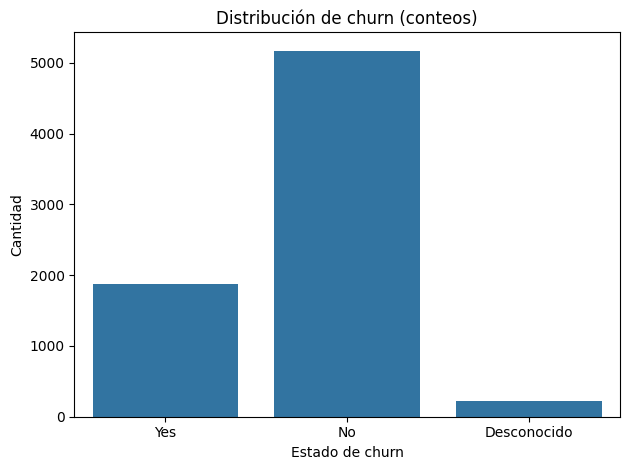

,conteo,porcentaje_%
churn,,
No,5174,71.2
Yes,1869,25.7
Desconocido,224,3.1


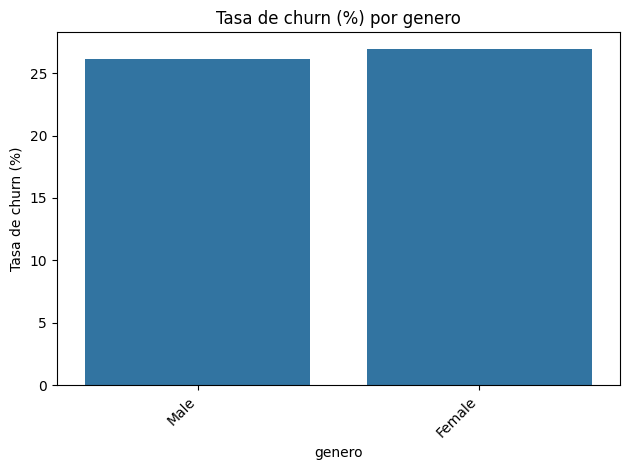

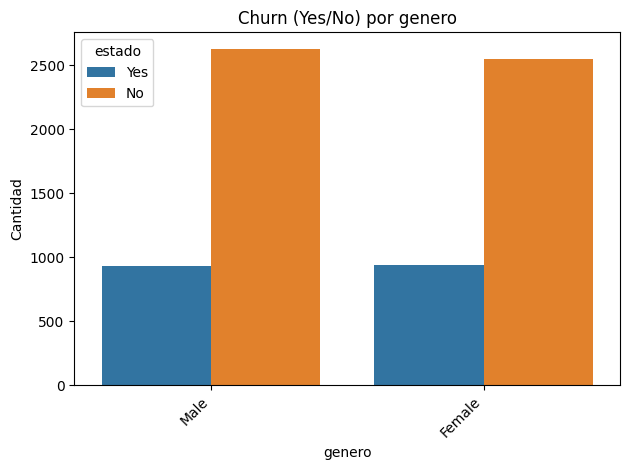

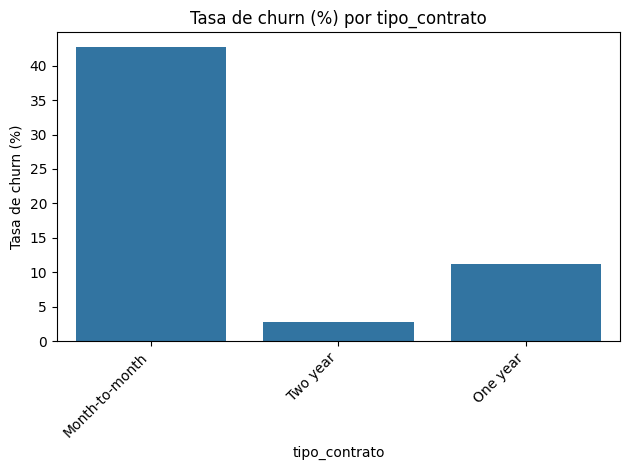

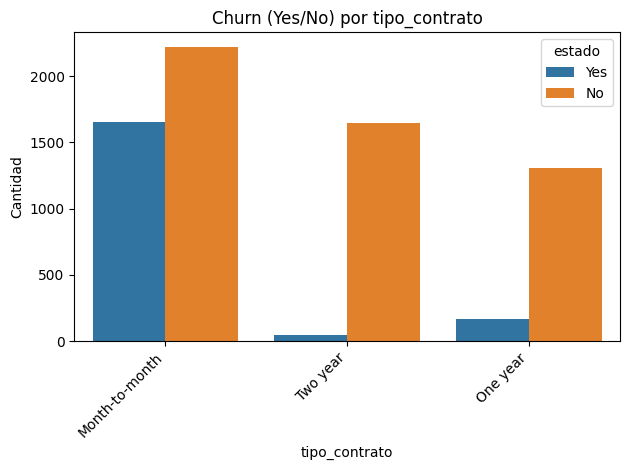

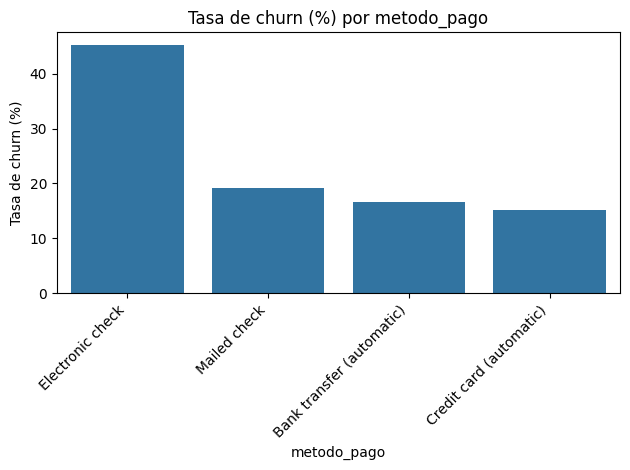

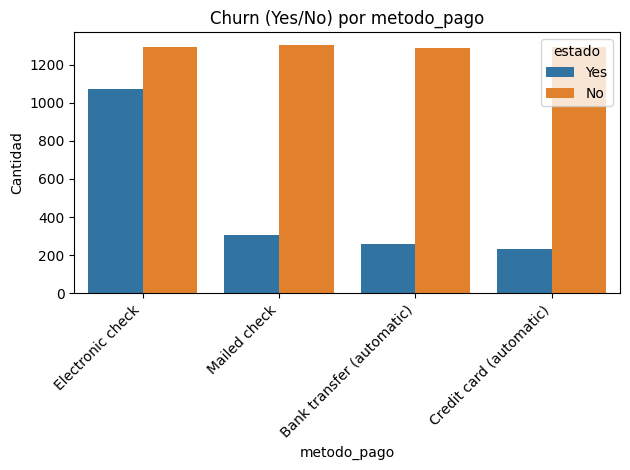

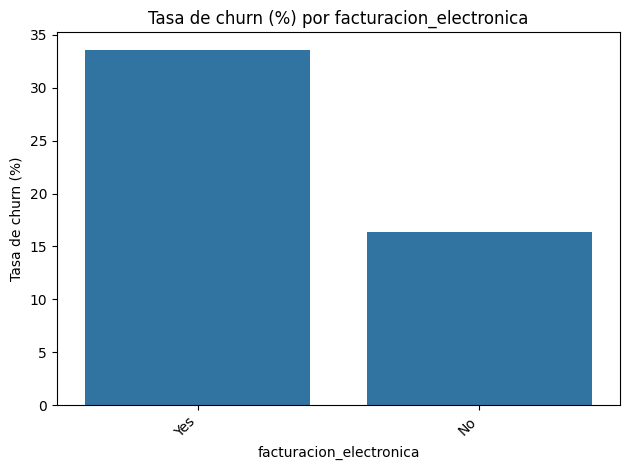

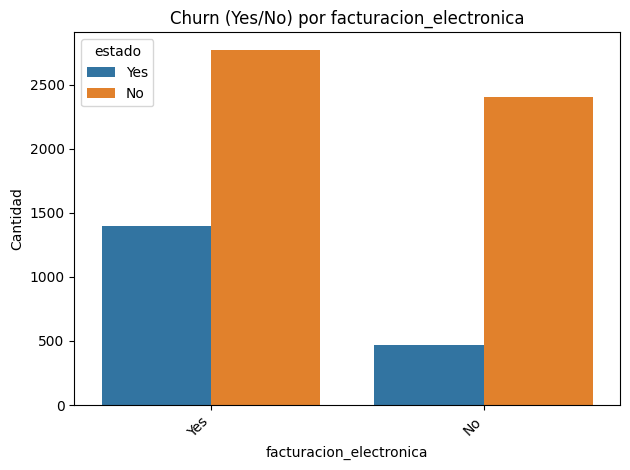

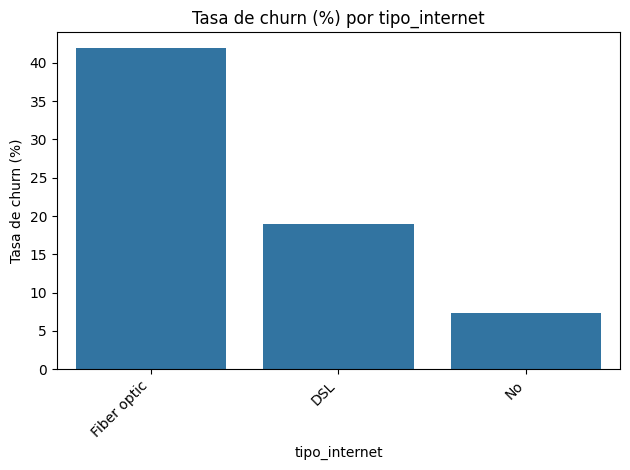

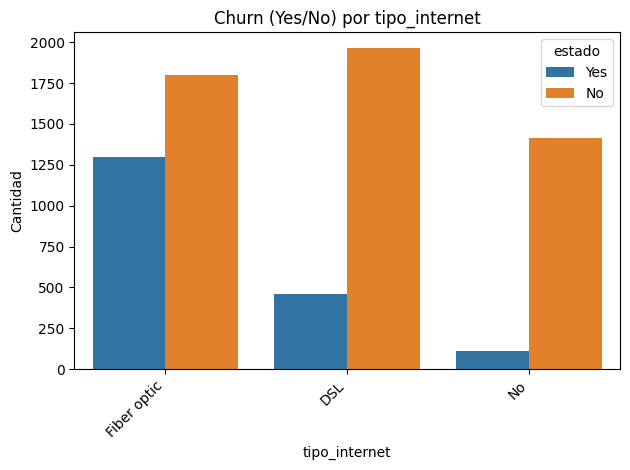

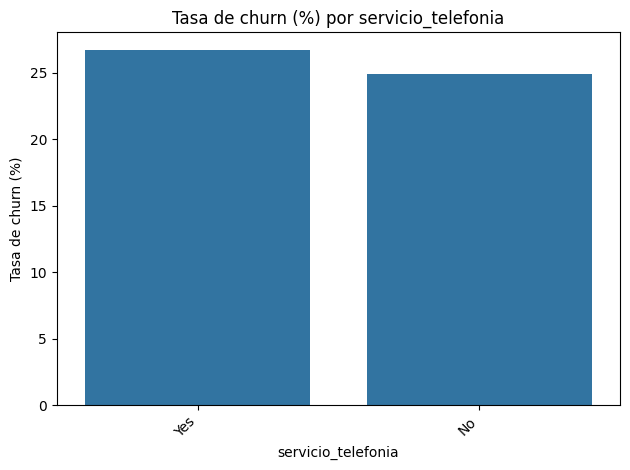

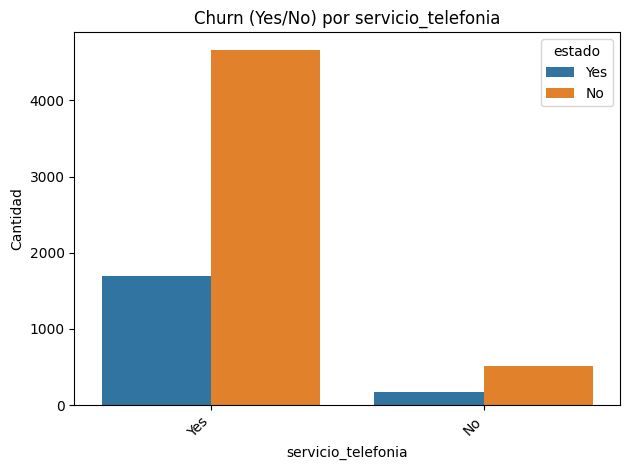

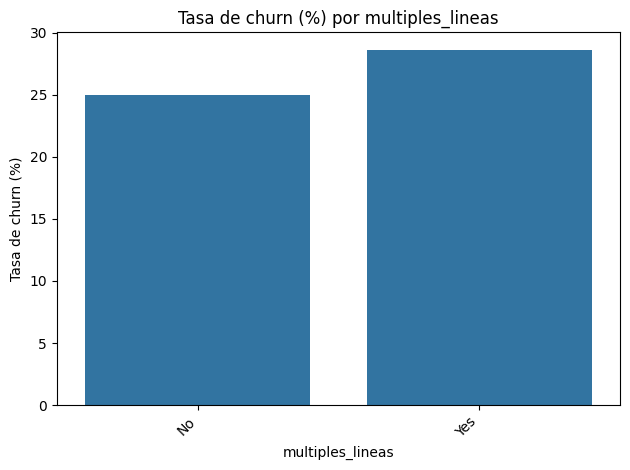

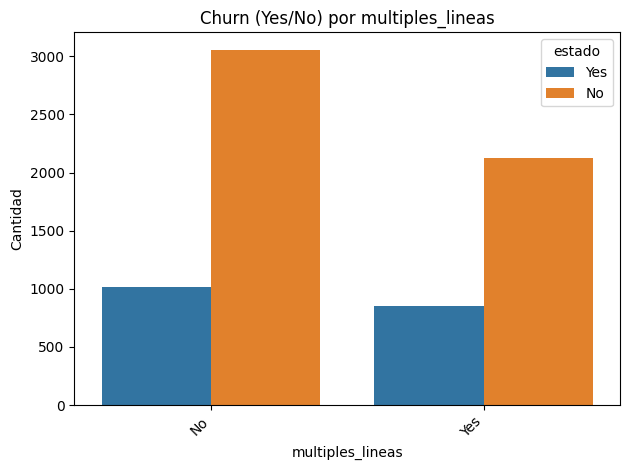

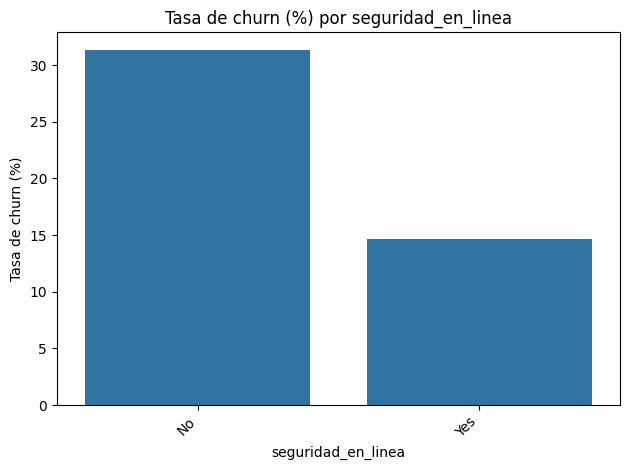

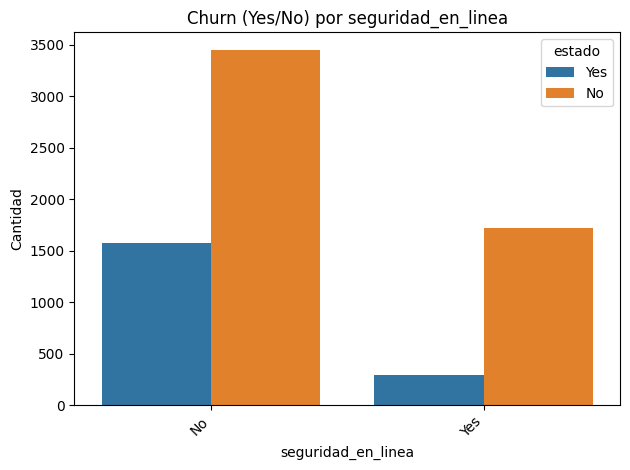

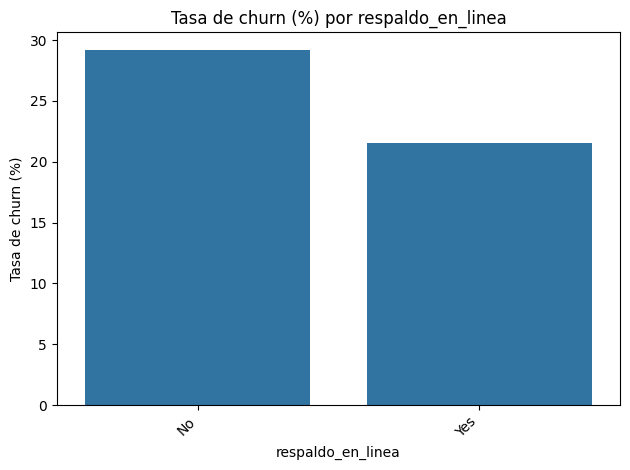

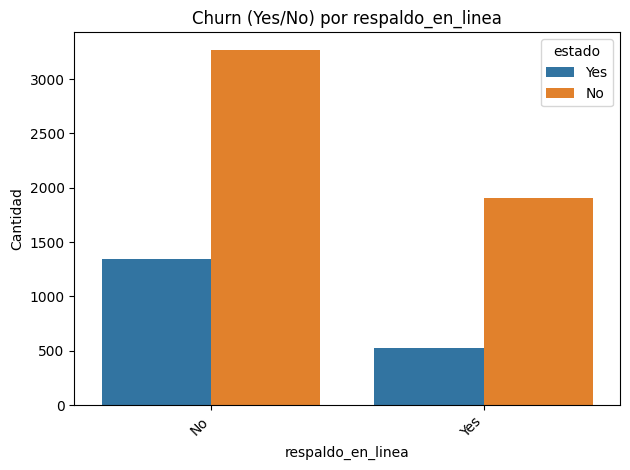

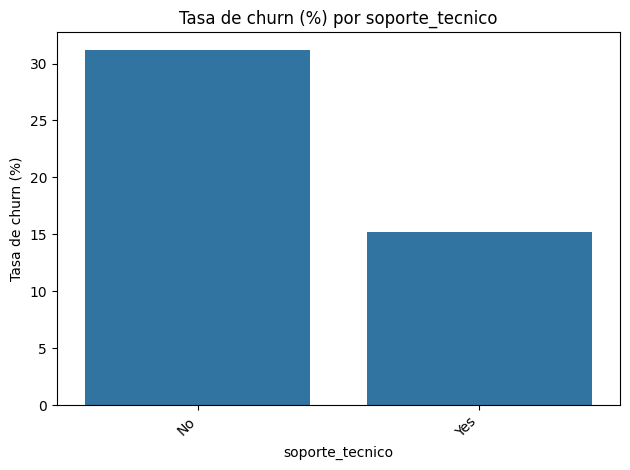

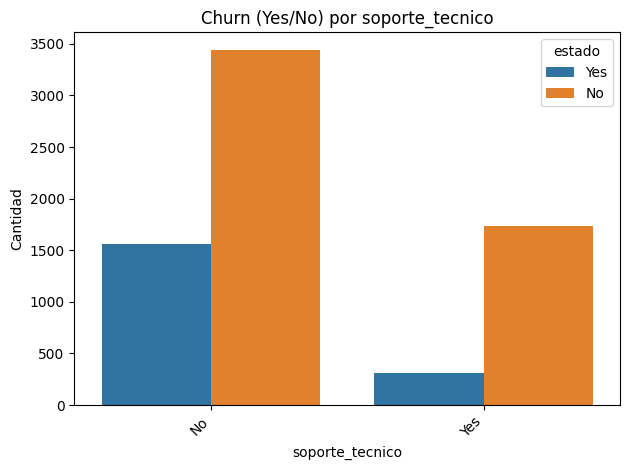

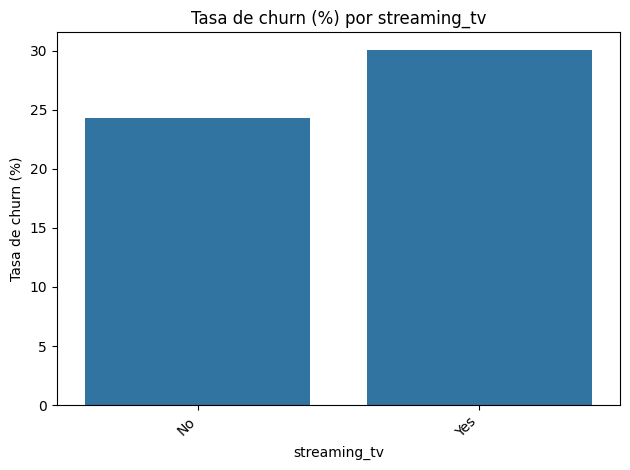

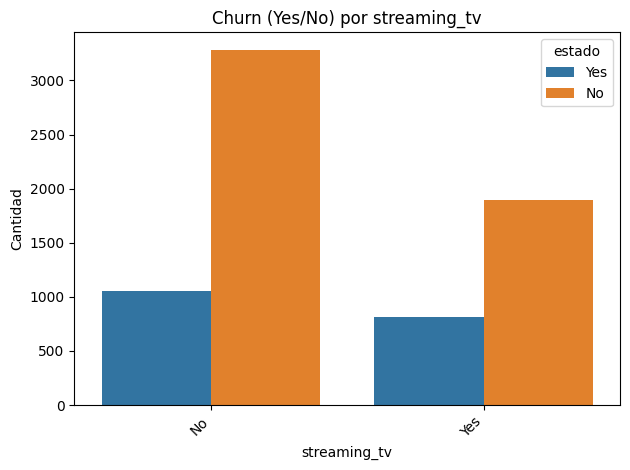

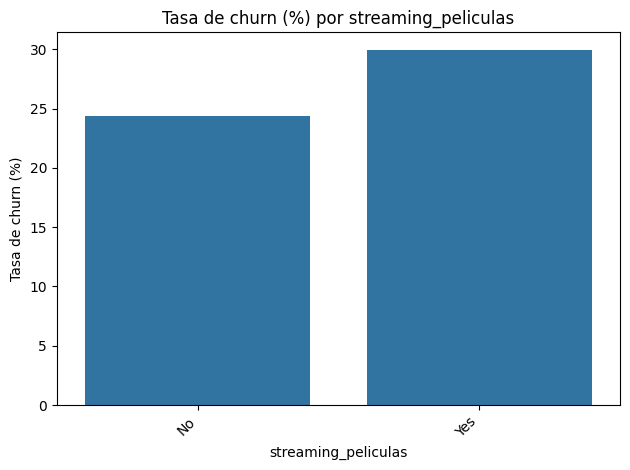

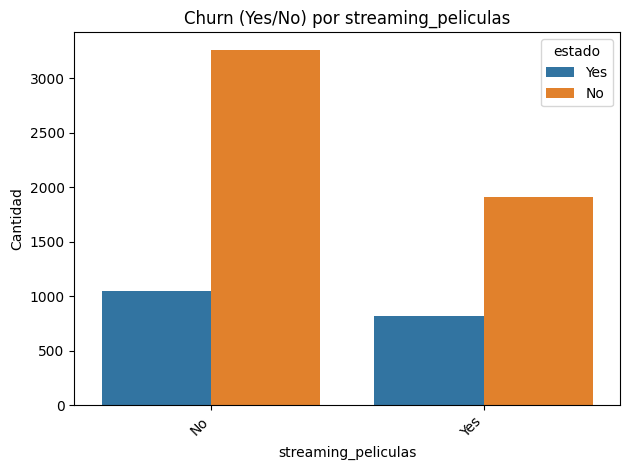

In [40]:
# 📦 Instalar (si hiciera falta en tu Colab)
# !pip install seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# ==== 1) Distribución de churn (conteos y %)
orden = [c for c in ['Yes','No','Desconocido'] if c in df_std_full_es['churn'].unique()]

plt.figure()
sns.countplot(data=df_std_full_es, x='churn', order=orden)
plt.title('Distribución de churn (conteos)')
plt.xlabel('Estado de churn'); plt.ylabel('Cantidad'); plt.tight_layout()
plt.show()

# Tabla %:
vc = df_std_full_es['churn'].value_counts(dropna=False)
pct = (vc/len(df_std_full_es)*100).round(1)
display(pd.DataFrame({'conteo': vc, 'porcentaje_%': pct}))

# ==== 2) Tasa de churn por categórica (función básica)
def tasa_churn_por_categoria(df, col):
    # Solo Yes/No para tasa:
    s = df['churn'].astype(str).str.strip()
    mask = s.isin(['Yes','No'])
    tmp = df.loc[mask, [col]].copy()
    tmp['churn'] = s[mask]

    tabla = tmp.groupby(col)['churn'].value_counts().unstack(fill_value=0)
    if 'Yes' not in tabla.columns: tabla['Yes'] = 0
    if 'No' not in tabla.columns:  tabla['No']  = 0
    tabla['clientes'] = tabla['Yes'] + tabla['No']
    tabla['tasa_churn_%'] = (tabla['Yes'] / tabla['clientes'].where(tabla['clientes']!=0)).fillna(0) * 100
    tabla = tabla.sort_values('clientes', ascending=False)
    return tabla.reset_index(names=col)

# Categóricas a mostrar (usa solo las que existan)
cat_cols = [c for c in [
    'genero','tipo_contrato','metodo_pago','facturacion_electronica',
    'tipo_internet','servicio_telefonia','multiples_lineas',
    'seguridad_en_linea','respaldo_en_linea','soporte_tecnico',
    'streaming_tv','streaming_peliculas'
] if c in df_std_full_es.columns]

for c in cat_cols:
    df_rate = tasa_churn_por_categoria(df_std_full_es, c).head(10)

    # Barras de tasa de churn
    plt.figure()
    sns.barplot(data=df_rate, x=c, y='tasa_churn_%')
    plt.title(f'Tasa de churn (%) por {c}')
    plt.xlabel(c); plt.ylabel('Tasa de churn (%)')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.show()

    # Barras apiladas de Yes/No (conteos)
    df_melt = df_rate.melt(id_vars=[c,'clientes','tasa_churn_%'], value_vars=['Yes','No'],
                           var_name='estado', value_name='conteo')
    plt.figure()
    sns.barplot(data=df_melt, x=c, y='conteo', hue='estado')
    plt.title(f'Churn (Yes/No) por {c}')
    plt.xlabel(c); plt.ylabel('Cantidad')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.show()


Opción B — Plotly Express (interactivo)

In [46]:
# 📦 Instalar (si hiciera falta en tu Colab)
# !pip install plotly --quiet

import numpy as np
import pandas as pd
import plotly.express as px
from IPython.display import display

# ==== 1) Pie y barras de churn
vc = df_std_full_es['churn'].value_counts()
fig = px.bar(vc, title="Distribución de churn (conteos)", labels={'value':'Conteo','index':'Estado'})
fig.update_layout(xaxis_title='Estado de churn', yaxis_title='Cantidad')
fig.show()

# Torta solo Yes/No
mask_bin = df_std_full_es['churn'].astype(str).str.strip().isin(['Yes','No'])
vc_bin = df_std_full_es.loc[mask_bin, 'churn'].value_counts()
fig = px.pie(values=vc_bin.values, names=vc_bin.index, title='Proporción de churn (solo Yes/No)')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# ==== 2) Tasa de churn por categórica (función)
def tasa_churn_por_categoria(df, col):
    s = df['churn'].astype(str).str.strip()
    mask = s.isin(['Yes','No'])
    tmp = df.loc[mask, [col]].copy()
    tmp['churn'] = s[mask]
    tabla = tmp.groupby(col)['churn'].value_counts().unstack(fill_value=0)
    for lbl in ['Yes','No']:
        if lbl not in tabla.columns: tabla[lbl] = 0
    tabla['clientes'] = tabla['Yes'] + tabla['No']
    tabla['tasa_churn_%'] = (tabla['Yes'] / tabla['clientes'].where(tabla['clientes']!=0)).fillna(0) * 100
    return tabla.reset_index(names=col).sort_values('clientes', ascending=False)

cat_cols = [c for c in [
    'genero','tipo_contrato','metodo_pago','facturacion_electronica',
    'tipo_internet','servicio_telefonia','multiples_lineas',
    'seguridad_en_linea','respaldo_en_linea','soporte_tecnico',
    'streaming_tv','streaming_peliculas'
] if c in df_std_full_es.columns]

for c in cat_cols:
    df_rate = tasa_churn_por_categoria(df_std_full_es, c).head(10)

    # Tasa de churn por categoría
    fig = px.bar(df_rate, x=c, y='tasa_churn_%',
                 title=f'Tasa de churn (%) por {c}',
                 labels={c:c, 'tasa_churn_%':'Tasa de churn (%)'},
                 hover_data=['clientes','Yes','No'])
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()

    # Conteos Yes/No apilados
    df_melt = df_rate.melt(id_vars=[c,'clientes','tasa_churn_%'],
                           value_vars=['Yes','No'], var_name='estado', value_name='conteo')
    fig = px.bar(df_melt, x=c, y='conteo', color='estado', barmode='stack',
                 title=f'Churn (Yes/No) por {c}', labels={c:c, 'conteo':'Cantidad'})
    fig.update_layout(xaxis_tickangle=-45)
    fig.show()


📈 Numéricos vs Churn

In [43]:
# 📈 Numéricos vs Churn (distribuciones y métricas)
# Requiere: df_std_full_es con 'churn' (Yes/No/Desconocido)
# Elige librería de gráficos:
USE_PLOTLY = True  # <- pon True para usar Plotly Express (interactivo)

import pandas as pd
from IPython.display import display

# 0) DF y columnas numéricas de interés (en español)
if 'df_std_full_es' not in globals():
    raise RuntimeError("Falta df_std_full_es. Ejecuta antes la traducción/estandarización.")

df_num = df_std_full_es.copy()

candidatas = ['antiguedad_meses', 'cargo_mensual', 'cargo_total', 'cuentas_diarias']
num_cols = [c for c in candidatas if c in df_num.columns]
if not num_cols:
    # fallback: detecta numéricas automáticamente
    num_cols = list(df_num.select_dtypes(include='number').columns)

if not num_cols:
    raise RuntimeError("No se encontraron columnas numéricas para analizar.")

# 1) Asegurar numérico
for c in num_cols:
    df_num[c] = pd.to_numeric(df_num[c], errors='coerce')

# 2) Filtrar a Yes/No para comparar (dejamos fuera 'Desconocido')
mask_bin = df_num['churn'].astype(str).str.strip().isin(['Yes','No'])
df_bin = df_num.loc[mask_bin, ['churn'] + num_cols].copy()

print("✅ Columnas numéricas analizadas:", num_cols)
print("📦 Muestras por churn:")
display(df_bin['churn'].value_counts().to_frame('conteo'))

# 3) Métricas por churn (count/mean/median/std/min/max)
print("\n📊 Métricas por churn (count/mean/median/std/min/max):")
desc = df_bin.groupby('churn')[num_cols].agg(['count','mean','median','std','min','max']).round(2)
display(desc)

# 4) Gráficos por variable: histogramas y boxplots
if USE_PLOTLY:
    # --- Plotly Express (interactivo) ---
    # !pip install plotly --quiet  # descomenta si hace falta
    import plotly.express as px

    for col in num_cols:
        # Histograma con box marginal (útil para ver dispersión)
        fig = px.histogram(df_bin, x=col, color='churn', nbins=30,
                           title=f"Distribución de {col} por churn",
                           marginal='box', barmode='overlay', opacity=0.75)
        fig.update_layout(xaxis_title=col, yaxis_title='Conteo')
        fig.show()

        # Boxplot separado (comparación directa)
        fig = px.box(df_bin, x='churn', y=col, points=False,
                     title=f"Boxplot de {col} por churn")
        fig.update_layout(xaxis_title='churn', yaxis_title=col)
        fig.show()
else:
    # --- Seaborn / Matplotlib (estático y simple) ---
    # !pip install seaborn --quiet  # descomenta si hace falta
    import matplotlib.pyplot as plt
    import seaborn as sns

    orden = [x for x in ['No','Yes'] if x in df_bin['churn'].unique()]

    for col in num_cols:
        # Histograma con KDE
        plt.figure()
        sns.histplot(data=df_bin, x=col, hue='churn', bins=30, kde=True, stat='density', common_norm=False)
        plt.title(f"Distribución de {col} por churn")
        plt.xlabel(col); plt.ylabel("Densidad")
        plt.tight_layout()
        plt.show()

        # Boxplot
        plt.figure()
        sns.boxplot(data=df_bin, x='churn', y=col, order=orden)
        plt.title(f"Boxplot de {col} por churn")
        plt.xlabel("churn"); plt.ylabel(col)
        plt.tight_layout()
        plt.show()


✅ Columnas numéricas analizadas: ['antiguedad_meses', 'cargo_mensual', 'cargo_total', 'cuentas_diarias']
📦 Muestras por churn:


,conteo
churn,
No,5174
Yes,1869



📊 Métricas por churn (count/mean/median/std/min/max):


antiguedad_meses                              cargo_mensual         \
                 count   mean median    std min max         count   mean   
churn                                                                      
No                5174  37.57   38.0  24.11   0  72          5174  61.27   
Yes               1869  17.98   10.0  19.53   1  72          1869  74.44   

                     ... cargo_total                          cuentas_diarias  \
      median    std  ...      median      std    min      max           count   
churn                ...                                                        
No     64.43  31.09  ...     1683.60  2329.46  18.80  8672.45            5174   
Yes    79.65  24.67  ...      703.55  1890.82  18.85  8684.80            1869   

                                      
       mean median   std   min   max  
churn                                 
No     2.01   2.12  1.02  0.60  3.90  
Yes    2.45   2.62  0.81  0.62  3.89  

[2 rows x 24 columns]

7) 📝 Informe final


# 📝 Informe Final — Proyecto *Churn de Clientes* (Telecom X)

**Contexto del autor:** informe elaborado por un perfil **principiante** en ciencia de datos (EDA/ETL y visualizaciones en Python), participante de **Alura ONE + Oracle**, con apoyo de IA para guiar el proceso.

## 🎯 Introducción
El objetivo es **entender la evasión (churn)** y los factores asociados a la cancelación, a partir de un dataset de clientes de Telecom X.  
Se busca dar **insights accionables** para retener clientes y alimentar futuros **modelos predictivos**.

**Dimensión del dataset usado:** 7267 filas × 33 columnas.  
**Distribución de churn:** Yes = 1869 (25.7%), No = 5174 (71.2%), Desconocido = 224 (3.1%).

## 🧼 Limpieza y Tratamiento de Datos (resumen)
- Importación desde URL y **normalización** del JSON.
- Limpieza de textos (**strip**).
- `churn`: vacíos → **"Desconocido"** (sin adivinar Yes/No).
- Unificación de **"No phone/internet service" → "No"** y **coherencias** (si no hay internet/teléfono, sus complementos quedan en "No").
- Conversión de **cargos** y **tenure** a numérico (errores → NaN).
- **Estandarización**: flags 0/1 (`*_flag`), cálculo de **cuentas_diarias** y **traducción completa** a español.

## 🔍 Análisis Exploratorio (fragmentos)
- **Churn global** (barras y torta) para ver magnitud.
- **Churn por categorías** (tipo de contrato, método de pago, tipo de internet), con **tasa de churn** (%).
- **Numéricos vs churn**: histogramas y boxplots por variable.

### 📌 Hallazgos rápidos (auto-resumen)
- Top tasa de churn por **tipo_contrato**: Month-to-month (42.7%).
- Top tasa de churn por **método de pago**: Electronic check (45.3%).
- Top tasa de churn por **tipo de internet**: Fiber optic (41.9%).

- Mayor brecha relativa en **antiguedad_meses**: clientes que cancelan presentan valores **menores** (~52.14%).

## ✅ Conclusiones e Insights
- Existen **diferencias por perfil de contrato y pago**: algunas categorías concentran una **tasa de churn** notablemente mayor.
- En variables numéricas, se observan **brechas** entre quienes cancelan y quienes no (ver tabla), útiles para priorizar **features** en un modelo.
- La presencia de **Desconocido** en `churn` sugiere revisar el **flujo de etiquetado** (separar “sigue activo” vs “sin etiqueta”).

## 🚀 Recomendaciones (accionables)
- **Contratos**: si *Month-to-month* aparece arriba, diseñar **incentivos** (descuentos/beneficios) para migrar a **contratos anuales** y reducir rotación.
- **Pagos**: si algún método (p. ej., *Electronic check*) tiene mayor churn, evaluar **fricciones** o incentivar métodos **automáticos** (transferencia/TC).
- **Onboarding y Early-life**: si `antiguedad_meses` de *Yes* tiende a ser menor, enfocar **programas de retención** en los **primeros meses**.
- **Planes/costos**: si `cargo_mensual` es mayor en *Yes*, revisar **paquetes premium** (precios, valor percibido, soporte proactivo).
- **Seguimiento continuo**: institucionalizar este tablero y alimentar un **modelo predictivo** (árboles/logística) para campañas **proactivas**.

> Nota: las visualizaciones y tablas siguientes refuerzan estas conclusiones.


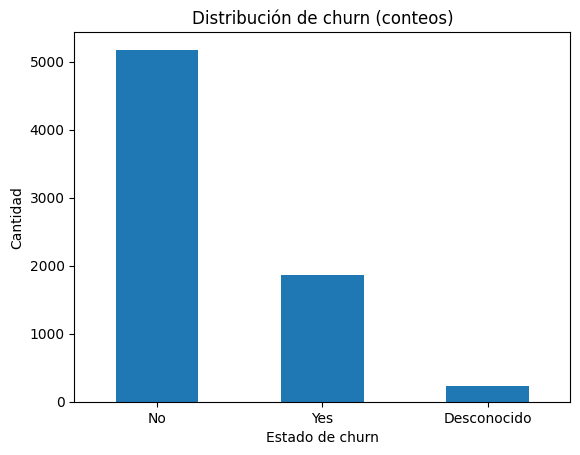

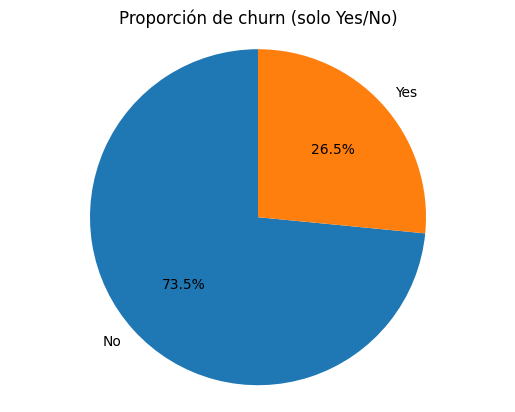

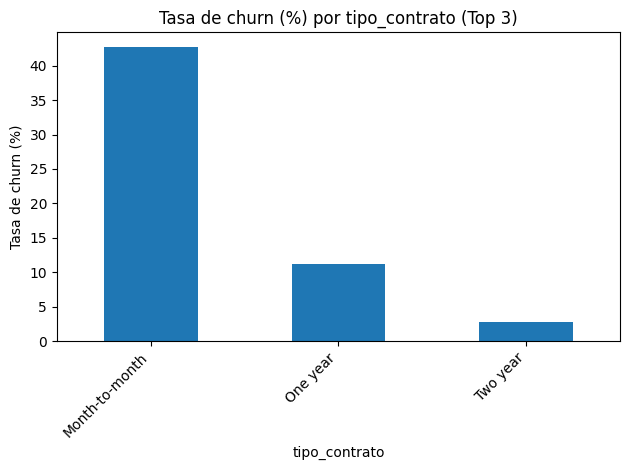

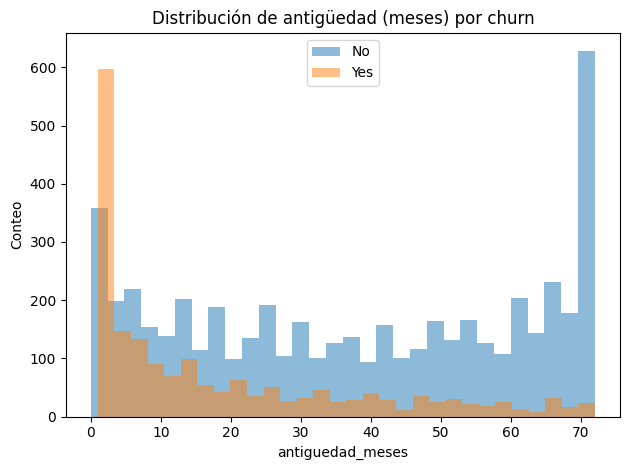

📊 Tasa de churn por tipo_contrato (filtrado por muestras ≥ 30)


churn,clientes,Yes,No,tasa_churn_%
tipo_contrato,,,,
Month-to-month,3875,1655,2220,42.71
One year,1473,166,1307,11.27
Two year,1695,48,1647,2.83



📊 Tasa de churn por metodo_pago (filtrado por muestras ≥ 30)


churn,clientes,Yes,No,tasa_churn_%
metodo_pago,,,,
Electronic check,2365,1071,1294,45.29
Mailed check,1612,308,1304,19.11
Bank transfer (automatic),1544,258,1286,16.71
Credit card (automatic),1522,232,1290,15.24



📊 Tasa de churn por tipo_internet (filtrado por muestras ≥ 30)


churn,clientes,Yes,No,tasa_churn_%
tipo_internet,,,,
Fiber optic,3096,1297,1799,41.89
DSL,2421,459,1962,18.96
No,1526,113,1413,7.40



📊 Brecha (Yes vs No) en variables numéricas


,variable,media_yes,media_no,brecha_abs,brecha_rel_%
0,antiguedad_meses,17.98,37.57,-19.59,-52.14
2,cargo_total,1531.80,2555.34,-1023.55,-40.06
1,cargo_mensual,74.44,61.27,13.18,21.51
3,cuentas_diarias,2.45,2.01,0.43,21.50


In [44]:
# 📝 INFORME FINAL — Telecom X (Churn)
# Requiere: df_std_full_es (con columnas en español) ya creado
# Nivel principiante: usa pandas + matplotlib, sin trucos avanzados.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

# -------------------------------------------------
# 0) Verificación básica y DF de trabajo
# -------------------------------------------------
if 'df_std_full_es' not in globals():
    raise RuntimeError("Falta df_std_full_es. Ejecuta las celdas anteriores.")

df = df_std_full_es.copy()
if 'churn' not in df.columns:
    raise RuntimeError("Falta la columna 'churn' en df_std_full_es.")

# Normalización ligera de churn para mostrar
df['churn'] = df['churn'].astype(str).str.strip().replace({'': 'Desconocido'})

# -------------------------------------------------
# 1) Métricas clave para el resumen
# -------------------------------------------------
filas, cols = df.shape
vc = df['churn'].value_counts(dropna=False)
yes_n = int(vc.get('Yes', 0))
no_n  = int(vc.get('No', 0))
des_n = int(vc.get('Desconocido', 0))
yes_p = (yes_n / filas * 100) if filas else 0
no_p  = (no_n  / filas * 100) if filas else 0
des_p = (des_n / filas * 100) if filas else 0

# Utilidad: tasas de churn por categoría (Yes/(Yes+No))
def churn_rate_table(df_in, col, min_clientes=30):
    # Solo Yes/No para calcular tasa
    s = df_in['churn'].astype(str).str.strip()
    mask = s.isin(['Yes','No'])
    tmp = df_in.loc[mask, [col]].copy()
    tmp['churn'] = s[mask]
    if tmp.empty:
        return pd.DataFrame()
    tabla = tmp.groupby(col)['churn'].value_counts().unstack(fill_value=0)
    if 'Yes' not in tabla.columns: tabla['Yes'] = 0
    if 'No' not in tabla.columns:  tabla['No']  = 0
    tabla['clientes'] = tabla['Yes'] + tabla['No']
    tabla = tabla[tabla['clientes'] >= min_clientes]  # filtra categorías pequeñas
    if tabla.empty:
        return tabla
    tabla['tasa_churn_%'] = (tabla['Yes'] / tabla['clientes'] * 100)
    tabla = tabla.sort_values('tasa_churn_%', ascending=False)
    return tabla

rate_contrato = churn_rate_table(df, 'tipo_contrato') if 'tipo_contrato' in df.columns else pd.DataFrame()
rate_pago     = churn_rate_table(df, 'metodo_pago')   if 'metodo_pago' in df.columns else pd.DataFrame()
rate_inet     = churn_rate_table(df, 'tipo_internet') if 'tipo_internet' in df.columns else pd.DataFrame()

top_contrato = (rate_contrato.head(1).index[0], float(rate_contrato.head(1)['tasa_churn_%'].iloc[0])) if not rate_contrato.empty else (None, None)
top_pago     = (rate_pago.head(1).index[0],     float(rate_pago.head(1)['tasa_churn_%'].iloc[0]))     if not rate_pago.empty     else (None, None)
top_inet     = (rate_inet.head(1).index[0],     float(rate_inet.head(1)['tasa_churn_%'].iloc[0]))     if not rate_inet.empty     else (None, None)

# Brecha (Yes vs No) en numéricos clave
num_candidatas = [c for c in ['antiguedad_meses','cargo_mensual','cargo_total','cuentas_diarias'] if c in df.columns]
brechas = []
if num_candidatas:
    s = df['churn'].astype(str).str.strip()
    mask = s.isin(['Yes','No'])
    d = df.loc[mask, ['churn']+num_candidatas].copy()
    for col in num_candidatas:
        d[col] = pd.to_numeric(d[col], errors='coerce')
    for col in num_candidatas:
        media_yes = float(d.loc[d['churn']=='Yes', col].mean())
        media_no  = float(d.loc[d['churn']=='No',  col].mean())
        if np.isfinite(media_yes) and np.isfinite(media_no):
            brecha_abs = media_yes - media_no
            brecha_rel = (brecha_abs / media_no * 100) if media_no != 0 else np.nan
            brechas.append([col, media_yes, media_no, brecha_abs, brecha_rel])
brechas_df = pd.DataFrame(brechas, columns=['variable','media_yes','media_no','brecha_abs','brecha_rel_%'])
brechas_df = brechas_df.sort_values('brecha_rel_%', key=lambda s: s.abs(), ascending=False)

# Para destacar en el texto
dest_var = None
dest_pct = None
dest_sign = None
if not brechas_df.empty and np.isfinite(brechas_df['brecha_rel_%'].iloc[0]):
    dest_var = brechas_df['variable'].iloc[0]
    dest_pct = float(brechas_df['brecha_rel_%'].iloc[0])
    dest_sign = "mayores" if dest_pct>0 else "menores"

# -------------------------------------------------
# 2) Informe en Markdown (texto)
# -------------------------------------------------
md = f"""
# 📝 Informe Final — Proyecto *Churn de Clientes* (Telecom X)

**Contexto del autor:** informe elaborado por un perfil **principiante** en ciencia de datos (EDA/ETL y visualizaciones en Python), participante de **Alura ONE + Oracle**, con apoyo de IA para guiar el proceso.

## 🎯 Introducción
El objetivo es **entender la evasión (churn)** y los factores asociados a la cancelación, a partir de un dataset de clientes de Telecom X.
Se busca dar **insights accionables** para retener clientes y alimentar futuros **modelos predictivos**.

**Dimensión del dataset usado:** {filas} filas × {cols} columnas.
**Distribución de churn:** Yes = {yes_n} ({yes_p:.1f}%), No = {no_n} ({no_p:.1f}%), Desconocido = {des_n} ({des_p:.1f}%).

## 🧼 Limpieza y Tratamiento de Datos (resumen)
- Importación desde URL y **normalización** del JSON.
- Limpieza de textos (**strip**).
- `churn`: vacíos → **"Desconocido"** (sin adivinar Yes/No).
- Unificación de **"No phone/internet service" → "No"** y **coherencias** (si no hay internet/teléfono, sus complementos quedan en "No").
- Conversión de **cargos** y **tenure** a numérico (errores → NaN).
- **Estandarización**: flags 0/1 (`*_flag`), cálculo de **cuentas_diarias** y **traducción completa** a español.

## 🔍 Análisis Exploratorio (fragmentos)
- **Churn global** (barras y torta) para ver magnitud.
- **Churn por categorías** (tipo de contrato, método de pago, tipo de internet), con **tasa de churn** (%).
- **Numéricos vs churn**: histogramas y boxplots por variable.

### 📌 Hallazgos rápidos (auto-resumen)
- Top tasa de churn por **tipo_contrato**: {top_contrato[0]} ({top_contrato[1]:.1f}%){"." if top_contrato[0] else " (no disponible)."}
- Top tasa de churn por **método de pago**: {top_pago[0]} ({top_pago[1]:.1f}%){"." if top_pago[0] else " (no disponible)."}
- Top tasa de churn por **tipo de internet**: {top_inet[0]} ({top_inet[1]:.1f}%){"." if top_inet[0] else " (no disponible)."}

{"- Mayor brecha relativa en **"+dest_var+"**: clientes que cancelan presentan valores **"+dest_sign+"** (~"+str(abs(dest_pct))[:5]+"%)." if dest_var else ""}

## ✅ Conclusiones e Insights
- Existen **diferencias por perfil de contrato y pago**: algunas categorías concentran una **tasa de churn** notablemente mayor.
- En variables numéricas, se observan **brechas** entre quienes cancelan y quienes no (ver tabla), útiles para priorizar **features** en un modelo.
- La presencia de **Desconocido** en `churn` sugiere revisar el **flujo de etiquetado** (separar “sigue activo” vs “sin etiqueta”).

## 🚀 Recomendaciones (accionables)
- **Contratos**: si *Month-to-month* aparece arriba, diseñar **incentivos** (descuentos/beneficios) para migrar a **contratos anuales** y reducir rotación.
- **Pagos**: si algún método (p. ej., *Electronic check*) tiene mayor churn, evaluar **fricciones** o incentivar métodos **automáticos** (transferencia/TC).
- **Onboarding y Early-life**: si `antiguedad_meses` de *Yes* tiende a ser menor, enfocar **programas de retención** en los **primeros meses**.
- **Planes/costos**: si `cargo_mensual` es mayor en *Yes*, revisar **paquetes premium** (precios, valor percibido, soporte proactivo).
- **Seguimiento continuo**: institucionalizar este tablero y alimentar un **modelo predictivo** (árboles/logística) para campañas **proactivas**.

> Nota: las visualizaciones y tablas siguientes refuerzan estas conclusiones.
"""
display(Markdown(md))

# -------------------------------------------------
# 3) Visualizaciones clave (simples con matplotlib)
# -------------------------------------------------

# 3.1 Churn global (barras + torta)
vc_plot = df['churn'].value_counts()
plt.figure()
vc_plot.plot(kind='bar')
plt.title('Distribución de churn (conteos)')
plt.xlabel('Estado de churn'); plt.ylabel('Cantidad'); plt.xticks(rotation=0)
plt.show()

mask_bin = df['churn'].isin(['Yes','No'])
vc_bin = df.loc[mask_bin,'churn'].value_counts()
plt.figure()
plt.pie(vc_bin.values, labels=vc_bin.index, autopct='%1.1f%%', startangle=90)
plt.title('Proporción de churn (solo Yes/No)'); plt.axis('equal')
plt.show()

# 3.2 Tasa de churn por tipo de contrato (TOP 3)
if not rate_contrato.empty:
    top3 = rate_contrato.head(3)
    plt.figure()
    top3['tasa_churn_%'].plot(kind='bar')
    plt.title('Tasa de churn (%) por tipo_contrato (Top 3)')
    plt.xlabel('tipo_contrato'); plt.ylabel('Tasa de churn (%)')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout()
    plt.show()

# 3.3 Antigüedad (histogramas sobrepuestos por churn)
if 'antiguedad_meses' in df.columns:
    d2 = df.loc[df['churn'].isin(['Yes','No']), ['churn','antiguedad_meses']].copy()
    d2['antiguedad_meses'] = pd.to_numeric(d2['antiguedad_meses'], errors='coerce')
    plt.figure()
    for estado in ['No','Yes']:
        vals = d2.loc[d2['churn']==estado, 'antiguedad_meses'].dropna()
        plt.hist(vals, bins=30, alpha=0.5, label=estado)
    plt.title('Distribución de antigüedad (meses) por churn')
    plt.xlabel('antiguedad_meses'); plt.ylabel('Conteo'); plt.legend()
    plt.tight_layout(); plt.show()

# -------------------------------------------------
# 4) Tablas de apoyo (tasas y brechas)
# -------------------------------------------------
if not rate_contrato.empty:
    print("📊 Tasa de churn por tipo_contrato (filtrado por muestras ≥ 30)")
    display(rate_contrato[['clientes','Yes','No','tasa_churn_%']].round(2))

if not rate_pago.empty:
    print("\n📊 Tasa de churn por metodo_pago (filtrado por muestras ≥ 30)")
    display(rate_pago[['clientes','Yes','No','tasa_churn_%']].round(2))

if not rate_inet.empty:
    print("\n📊 Tasa de churn por tipo_internet (filtrado por muestras ≥ 30)")
    display(rate_inet[['clientes','Yes','No','tasa_churn_%']].round(2))

if not brechas_df.empty:
    print("\n📊 Brecha (Yes vs No) en variables numéricas")
    display(brechas_df.round(2))
